In [1]:
import numpy as np
import rmgpy.tools.uncertainty

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the model
chemkin = '../butane/chem_annotated.inp'
species_dict = '../butane/species_dictionary.txt'

uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='rmg_uncertainty')
uncertainty.load_model(chemkin, species_dict)




# TODO - force the user to provide the input file used to generate the mechanism to ensure databases are really the same
# load the database
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
# note - this cell stalls out on Discovery
thermo_libs = [
    'BurkeH2O2',
    'primaryThermoLibrary',
    'FFCM1(-)',
    'CurranPentane',
    'Klippenstein_Glarborg2016',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo',
    'CBS_QB3_1dHR',
]

kinetic_libs = [
    'FFCM1(-)',
    'CurranPentane',
    'combustion_core/version5',
    'Klippenstein_Glarborg2016',
    'BurkeH2O2inArHe',
    'BurkeH2O2inN2',
]
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families='default',
    reaction_libraries=kinetic_libs,
    kinetics_depositories=['training'],
)


In [3]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [4]:
Sigma, labels = uncertainty.get_uncertainty_covariance_matrix()

In [5]:
Sigma.shape

(1932, 1932)

In [6]:
len(uncertainty.reaction_list)+len(uncertainty.species_list)

1932

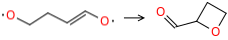

In [7]:
labels[-1]

## Example for Cov(rxn370, rxn370)

In [8]:
i = 370
print(uncertainty.reaction_list[i].family)
print(uncertainty.reaction_list[i])
print(uncertainty.kinetic_input_uncertainties[i])


H_Abstraction
CH3CHO(35) + SC4H9(183) <=> CH2CHO(21) + butane(1)
4.2527664246144505


In [9]:
entry = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]

In [10]:
training_rxns = [x for x in entry['training']]
weights = [x[2] for x in training_rxns]
d = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['degeneracy']
# d = 1.0
k_nonexact = 3.5
k_rule = 0.5
k_family = 1.0
N = len(training_rxns)

### Variance
$Var(\ln k_{370}) = d^2 \left[ \sum_{i=1}^N \omega_i^2 Var(\ln k_{rule,i}) +  Var(\ln k_{family}) + \left[\log_{10}({N+1})\right]^2 Var(\ln k_{nonexact})\right]$

In [ ]:
nonexact_scaling = np.log10(N + 1) ** 2.0
var_370 = d ** 2.0 * (np.sum(np.float_power(weights, 2.0) * k_rule) + k_family + nonexact_scaling * k_nonexact)

In [ ]:
var_370

In [ ]:
var_370 / d / d

### Std Dev
$std(\ln k_{370}) = d \left[ \sum_{i=1}^N \omega_i \Delta\ln k_{rule,i} +  \Delta\ln k_{family} + \left[\log_{10}({N+1})\right] \Delta\ln k_{nonexact}\right]$

In [ ]:
std_370 = d * (np.sum(np.array(weights) * k_rule) + k_family + np.log10(N + 1) * k_nonexact)

In [ ]:
std_370

In [ ]:
std_370 / d

In [ ]:
entry

In [ ]:
# Compute uncorrelated uncertainties for all reactions and plot intrinsic vs. extrinsic

In [11]:
k_nonexact = 3.5
k_rule = 0.5
k_family = 1.0
k_train = 0.5
k_library = 0.5

stddevs = np.zeros(len(uncertainty.reaction_list))
variances = np.zeros(len(uncertainty.reaction_list))
std_int = np.zeros(len(uncertainty.reaction_list))
std_ext = np.zeros(len(uncertainty.reaction_list))
var_int = np.zeros(len(uncertainty.reaction_list))
var_ext = np.zeros(len(uncertainty.reaction_list))

for i in range(0, len(stddevs)):
    try:
        entry = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]

        training_rxns = [x for x in entry['training']]
        weights = [x[2] for x in training_rxns]
#         d = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['degeneracy']
        d = 1.0
        N = len(training_rxns)
        
        nonexact_scaling = np.log10(N + 1) ** 2.0
        variances[i] = d ** 2.0 * (np.sum(np.float_power(weights, 2.0) * k_rule) + k_family + nonexact_scaling * k_nonexact)
        var_int[i] = np.sum(np.float_power(weights, 2.0) * k_rule)
        var_ext[i] = k_family + nonexact_scaling * k_nonexact
        
        stddevs[i] = d * (np.sum(np.array(weights) * k_rule) + k_family + np.log10(N + 1) * k_nonexact)
        std_int[i] = np.sum(np.array(weights) * k_rule)
        std_ext[i] = k_family + np.log10(N + 1) * k_nonexact
        
        # Reaction matches a training reaction exactly
        if entry['exact']:
            variances[i] = k_train
            var_int[i] = k_train
            var_ext[i] = 0

            stddevs[i] = k_train
            std_int[i] = k_train
            std_ext[i] = 0
        
        # Autogenerated trees
        if entry['node']:
            if entry['node_std_dev'] == 0:
                print(i)
            variances[i] = entry['node_std_dev']
            var_int[i] = entry['node_std_dev']
            var_ext[i] = 0

            stddevs[i] = entry['node_std_dev']
            std_int[i] = entry['node_std_dev']
            std_ext[i] = 0


        
    except KeyError:
        variances[i] = k_library
        var_int[i] = k_library
        var_ext[i] = 0

        stddevs[i] = k_library
        std_int[i] = k_library
        std_ext[i] = 0



In [12]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[188]]

{'Library': 188}

In [13]:
std_ext[188]

0.0

Text(0, 0.5, 'Uncertainty (variance)')

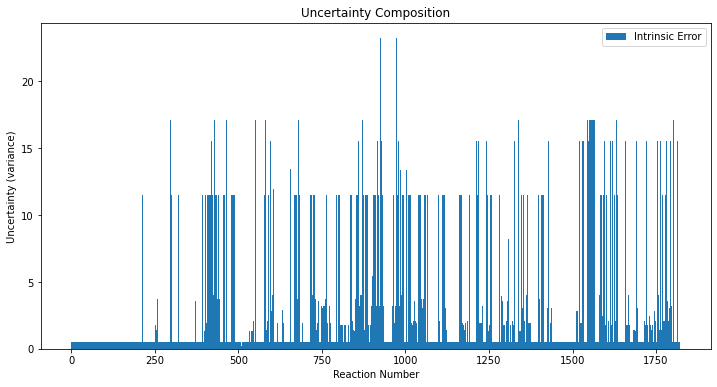

In [14]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.bar(np.arange(0, len(uncertainty.reaction_list)), variances, align='edge', width=1.0)

plt.title('Uncertainty Composition')
plt.legend(['Intrinsic Error', 'Extrinsic Error'])
plt.xlabel('Reaction Number')
plt.ylabel('Uncertainty (variance)')

In [15]:
a=np.arange(0, len(uncertainty.reaction_list))

In [16]:
a[210]

210

In [17]:
variances[200]

0.5

Text(0, 0.5, 'Uncertainty (variance)')

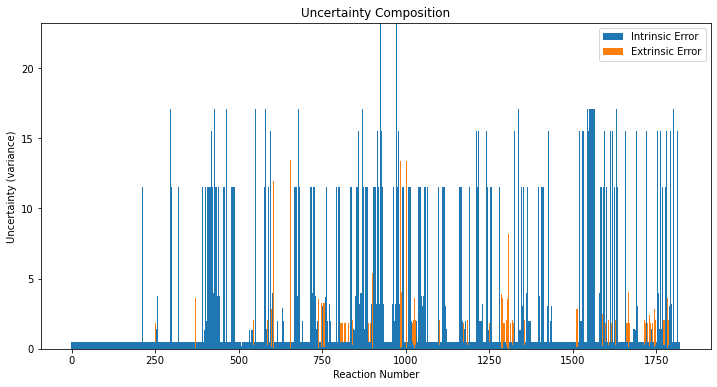

In [18]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.bar(np.arange(0, len(uncertainty.reaction_list)), var_int, width=1.0)
ax.bar(np.arange(0, len(uncertainty.reaction_list)), var_ext, bottom=var_int, width=1.0)

plt.title('Uncertainty Composition')
plt.legend(['Intrinsic Error', 'Extrinsic Error'])
plt.xlabel('Reaction Number')
plt.ylabel('Uncertainty (variance)')

Text(0, 0.5, 'Uncertainty (std dev)')

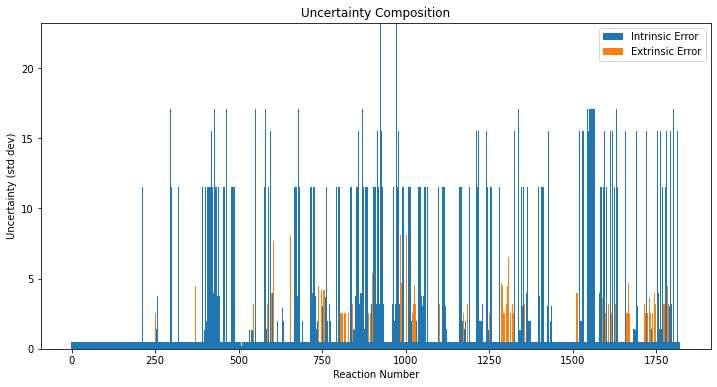

In [19]:

plt.figure(figsize=(12, 6))
ax = plt.gca()

ax.bar(np.arange(0, len(uncertainty.reaction_list)), std_int, width=1.0)
ax.bar(np.arange(0, len(uncertainty.reaction_list)), std_ext, bottom=std_int, width=1.0)

plt.title('Uncertainty Composition')
plt.legend(['Intrinsic Error', 'Extrinsic Error'])
plt.xlabel('Reaction Number')
plt.ylabel('Uncertainty (std dev)')

In [ ]:
stddevs[valid_indices]

In [ ]:
# plot bar graph of uncertainties

In [ ]:
stddevs

In [ ]:
str(uncertainty.reaction_list[0])

In [ ]:
reaction_order = np.arange(0, len(uncertainty.reaction_list))

In [ ]:
# List top 10 most uncertain reactions:
sorted_indices = [x for _,x in sorted(zip(variances,reaction_order))]

In [ ]:
# Top ten are the same because the autogenerated tree node dominate this list

In [ ]:
for i in range(1, 11):
    print(uncertainty.reaction_list[sorted_indices[-i]])
    print(uncertainty.reaction_sources_dict[uncertainty.reaction_list[sorted_indices[-i]]])
    print(uncertainty.reaction_sources_dict[uncertainty.reaction_list[sorted_indices[-i]]]['Rate Rules'][1]['node'])
    print()
    print()
                                    

In [ ]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[sorted_indices[-1]]]

In [ ]:
uncertainty.kinetic_input_uncertainties[sorted_indices[0]]